# Tutorial 1: calibration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os

In [2]:
url = 'https://raw.githubusercontent.com/oguerrer/ppi_app/main/code/ppi.py'
r = requests.get(url)
with open('ppi.py', 'w') as f:
    f.write(r.text)
import ppi

### Download datasets

In [20]:
file_names = ['I0', 'IF', 'success_rates', 'A', 'R', 'qm', 'rl', 'Bs', 'B_dict', 'parameters_original']

for file_name in file_names:
    url = 'https://raw.githubusercontent.com/oguerrer/ppi_app/main/data/benchmark/'+file_name+'.csv'
    r = requests.get(url)
    with open(os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

### Load all the data

In [3]:
I0 = np.loadtxt('I0.csv', delimiter=',')
IF = np.loadtxt('IF.csv', delimiter=',')
success_rates = np.loadtxt('success_rates.csv', delimiter=',')
A = np.loadtxt('A.csv', delimiter=',')
R = np.loadtxt('R.csv', delimiter=',')
qm = np.loadtxt('qm.csv', delimiter=',')
rl = np.loadtxt('rl.csv', delimiter=',')
Bs = np.loadtxt('Bs.csv', delimiter=',')
B_dict = dict([(int(key), [int(val)]) for key, val in np.loadtxt('B_dict.csv', delimiter=',')])

### Calibration with indicator time series only

In [5]:
parameters = ppi.calibrate(I0, IF, success_rates, parallel_processes=20, verbose=False)
df = pd.DataFrame(parameters[1::,:].astype(float), columns=parameters[0])

### Calibration with single total budget

In [6]:
Bs_mean = np.mean(Bs)
parameters = ppi.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs_mean, verbose=False)
df = pd.DataFrame(parameters[1::,:].astype(float), columns=parameters[0])

### Calibration with total budget time series

In [8]:
Bs_mean_ts = Bs.mean(axis=0)
parameters = ppi.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs_mean_ts, verbose=False)
df = pd.DataFrame(parameters[1::,:].astype(float), columns=parameters[0])

### Calibration with perfect budget matrix

In [10]:
Bs_perfect = np.vstack( (np.tile(Bs, (4,1)), Bs[0:5,:]) )
B_dict_perfect = dict([(i,[i]) for i in range(len(I0))])
parameters = ppi.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs_perfect, B_dict=B_dict_perfect, verbose=False)
df = pd.DataFrame(parameters[1::,:].astype(float), columns=parameters[0])

### Calibration with imperfect budget matrix and inditaror characteristics

In [16]:
parameters = ppi.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs, B_dict=B_dict, A=A, R=R, qm=qm, rl=rl, verbose=False)
dfp1 = pd.DataFrame(parameters[1::,:].astype(float), columns=parameters[0])

parameters = ppi.calibrate(I0, IF, success_rates, parallel_processes=20, Bs=Bs, B_dict=B_dict, A=A, R=R, qm=qm, rl=rl, verbose=False)
dfp2 = pd.DataFrame(parameters[1::,:].astype(float), columns=parameters[0])

### Verify robustness between two independent calibrations

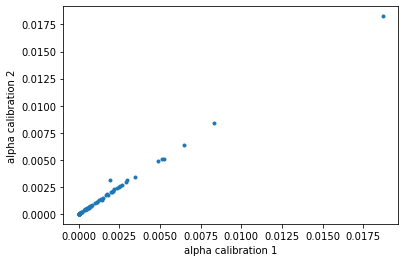

In [17]:
plt.plot(dfp1.alpha, dfp2.alpha, '.')
plt.xlabel('alpha calibration 1')
plt.ylabel('alpha calibration 2')
plt.show()

### Verify robustness between this calibration and the parameters obtained in the external benchmark

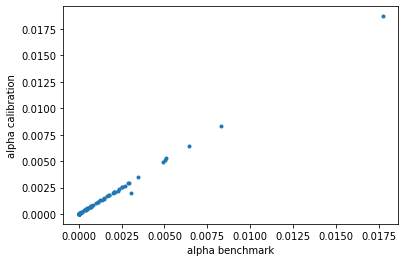

In [21]:
dfpb = pd.read_csv('parameters_original.csv')
plt.plot(dfpb.alpha, dfp1.alpha, '.')
plt.xlabel('alpha benchmark')
plt.ylabel('alpha calibration')
plt.show()

### Prospective simulations

In [22]:
# projected budget matrix
Bs_future = np.tile(Bs[:,-1], (100,1)).T
# Minimum and maximum values
Imin = np.zeros(len(I0))
Imax = np.ones(len(I0))
# paramters
alphas = dfp2.alpha.values.astype(float)
alphas_prime = dfp2.alpha_prime.values.astype(float)
betas = dfp2.beta.values.astype(float)

A single simulation

In [23]:
outputs = ppi.run_ppi(I0=I0, alphas=alphas, alphas_prime=alphas_prime, 
                          betas=betas, A=A, R=R, qm=qm, rl=rl,
                          Bs=Bs_future, B_dict=B_dict, Imin=Imin, Imax=Imax)

# unpack matrices with time series
tsI, tsC, tsF, tsP, tsS, tsG = outputs

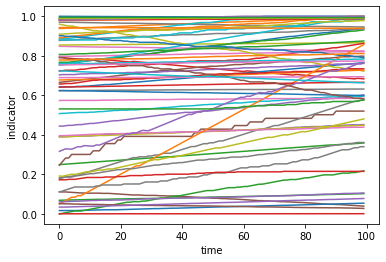

In [24]:
# plot projected time series
for serie in tsI:
    plt.plot(serie)
plt.xlabel('time')
plt.ylabel('indicator')
plt.show()

Several simulations and taking the average dynamics

In [25]:
all_outputs = []
for sim in range(100):
    outputs = ppi.run_ppi(I0=I0, alphas=alphas, alphas_prime=alphas_prime, 
                          betas=betas, A=A, R=R, qm=qm, rl=rl,
                          Bs=Bs_future, B_dict=B_dict, Imin=Imin, Imax=Imax)
    all_outputs.append(outputs)

# unpack Monte Carlo samples
tsI, tsC, tsF, tsP, tsS, tsG = zip(*all_outputs)
# compute means
mean_tsI = np.mean(tsI, axis=0)

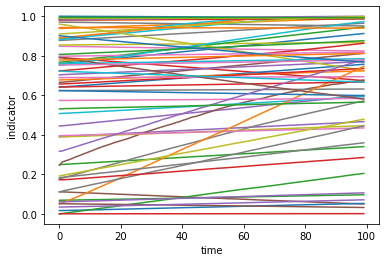

In [26]:
# plot projected time series
for serie in mean_tsI:
    plt.plot(serie)
plt.xlabel('time')
plt.ylabel('indicator')
plt.show()

A counterfactual with double the budget

In [27]:
all_outputs = []
for sim in range(100):
    outputs = ppi.run_ppi(I0=I0, alphas=alphas, alphas_prime=alphas_prime, 
                          betas=betas, A=A, R=R, qm=qm, rl=rl,
                          Bs=2*Bs_future, B_dict=B_dict, Imin=Imin, Imax=Imax)
    all_outputs.append(outputs)

# unpack Monte Carlo samples
tsI, tsC, tsF, tsP, tsS, tsG = zip(*all_outputs)
# compute means
mean_tsI = np.mean(tsI, axis=0)

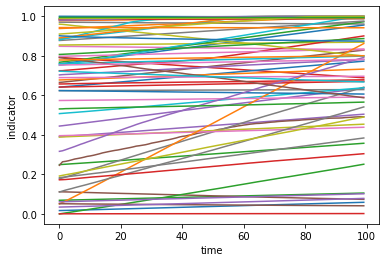

In [28]:
# plot projected time series
for serie in mean_tsI:
    plt.plot(serie)
plt.xlabel('time')
plt.ylabel('indicator')
plt.show()